In [80]:
import numpy as np
import matplotlib.pyplot as plt
import spectral as sp

from ipynb.fs.full.SeedMaskExtractor import find_seed_width_height_area, find_seed_mask
from ipynb.fs.full.SeedFinder import all_seeds

In [81]:
def display_band(band, title='band'):
    plt.imshow(band, cmap='gray', vmin=0, vmax=4095)
    plt.title(title)
    plt.colorbar()
    plt.show()

In [82]:
healthy_seed = np.load(all_seeds[0])
infected_seed = np.load(all_seeds[-1])

In [83]:
healthy_seed_mask_200, healthy_y_start, healthy_x_start = find_seed_mask(healthy_seed[:,:,200])
healthy_width, healthy_height, _, _, _ = find_seed_width_height_area(healthy_seed[:,:,200])
infected_seed_mask_200, infected_y_start, infected_x_start = find_seed_mask(infected_seed[:,:,200])
infected_width, infected_height, _, _, _ = find_seed_width_height_area(infected_seed[:,:,200])

In [84]:
healthy_seed_mask_all = healthy_seed[healthy_y_start:healthy_y_start+healthy_height,healthy_x_start:healthy_x_start+healthy_width,100:740]
infected_seed_mask_all = infected_seed[infected_y_start:infected_y_start+infected_height,infected_x_start:infected_x_start+infected_width,100:740]

In [85]:
def plot_spectra(spectra, title='Spectra'):
    plt.figure(figsize=(10, 6))
    for i, spectrum in enumerate(spectra):
        plt.plot(spectrum)
    plt.title(title)
    plt.xlabel('Band')
    plt.ylabel('Relative Reflectance / Intensity')
    plt.yscale('log')
    plt.show()

In [86]:
healthy_pixels = [(i, j) for i in range(0, healthy_seed_mask_all.shape[0], 10) for j in range(0, healthy_seed_mask_all.shape[1], 10) if healthy_seed_mask_200[i,j]]
healthy_seed_spectra = [healthy_seed_mask_all[y, x, :].squeeze() for y, x in healthy_pixels[20:24]]
infected_pixels = [(i, j) for i in range(0, infected_seed_mask_all.shape[0], 10) for j in range(0, infected_seed_mask_all.shape[1], 10) if infected_seed_mask_200[i,j]]
infected_seed_spectra = [infected_seed_mask_all[y, x, :].squeeze() for y, x in infected_pixels[20:24]]

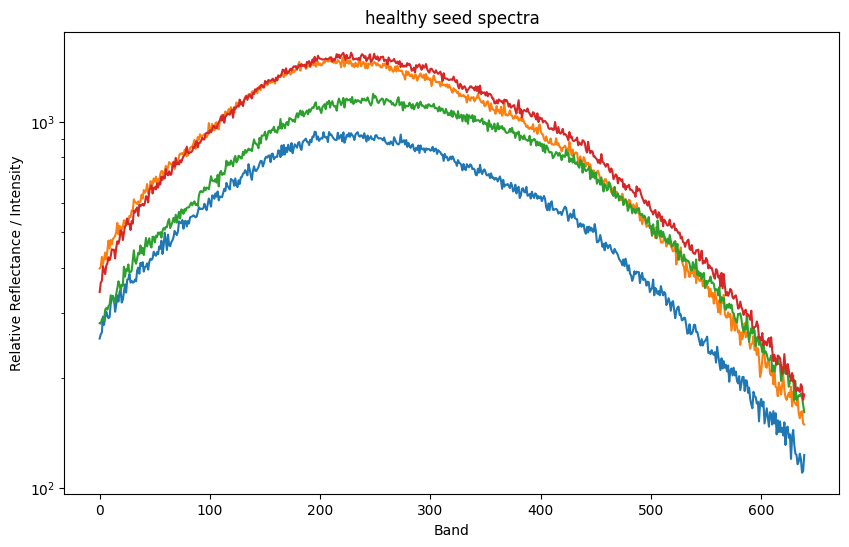

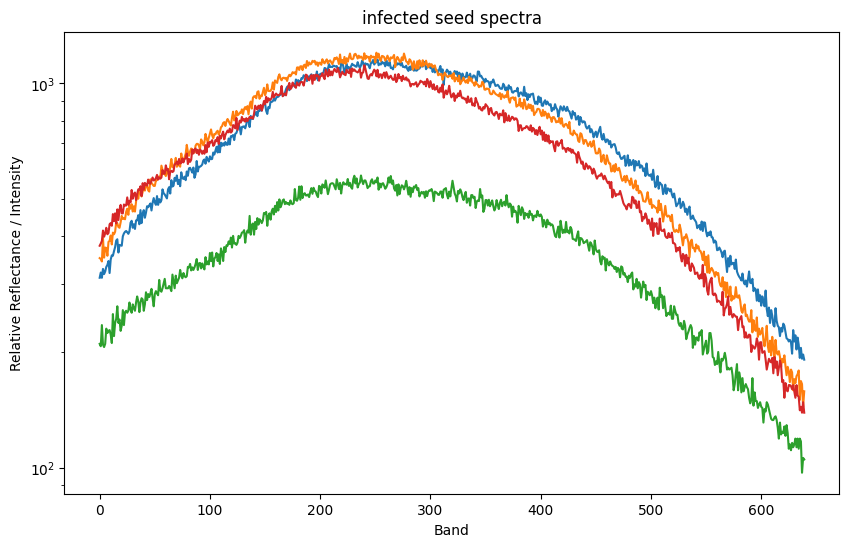

In [87]:
plot_spectra(healthy_seed_spectra, 'healthy seed spectra')
plot_spectra(infected_seed_spectra, 'infected seed spectra')

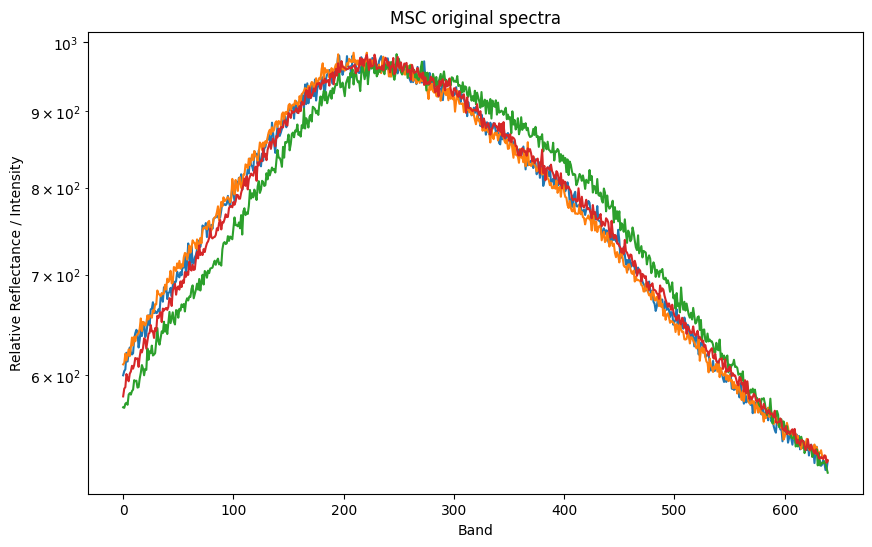

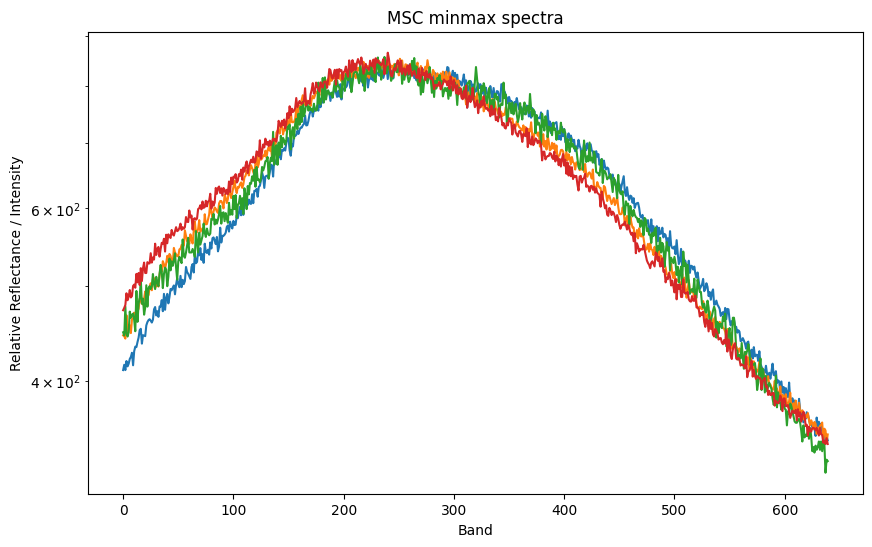

In [88]:
def apply_msc_and_shift_positive(image, ref_spectrum):
    # Apply MSC correction (this is your existing MSC process)
    corrected_spectra = []

    for spectrum in image:
        # Perform the MSC correction (standard MSC formula)
        corrected = (spectrum - np.mean(spectrum)) / np.std(spectrum)
        corrected = corrected * np.std(ref_spectrum) + np.mean(ref_spectrum)
        corrected_spectra.append(corrected)
    
    corrected_spectra = np.array(corrected_spectra)

    # Shift all values to ensure positivity
    min_value = np.min(corrected_spectra)
    
    if min_value < 0:
        # Shift spectra by the absolute value of the minimum (or a small constant)
        shift_value = np.abs(min_value)
        corrected_spectra += shift_value
    
    return corrected_spectra

ref_spectrum = np.mean(healthy_seed_spectra, axis=1)
healthy_msc_spectra = apply_msc_and_shift_positive(healthy_seed_spectra, ref_spectrum)
plot_spectra(healthy_msc_spectra, 'MSC original spectra')
ref_spectrum = np.mean(infected_seed_spectra, axis=1)
infected_msc_spectra = apply_msc_and_shift_positive(infected_seed_spectra, ref_spectrum)
plot_spectra(infected_msc_spectra, 'MSC minmax spectra')

In [89]:
def minmax_normalize(image):
    """
    Applies Min-Max normalization to a hyperspectral image.
    Each band is normalized independently to [0, 1].
    
    Parameters:
        image (numpy.ndarray): Hyperspectral image with shape (H, W, B)
                               where H = height, W = width, B = number of bands.
    Returns:
        numpy.ndarray: Min-Max normalized image with the same shape as input.
    """
    min_vals = np.min(image, axis=(0, 1), keepdims=True)  # Minimum per band
    max_vals = np.max(image, axis=(0, 1), keepdims=True)  # Maximum per band
    normalized = (image - min_vals) / (max_vals - min_vals + 1e-8)  # Avoid division by zero
    return normalized

healthy_minmax_spectra = minmax_normalize(healthy_seed_spectra)
infected_minmax_spectra = minmax_normalize(infected_seed_spectra)

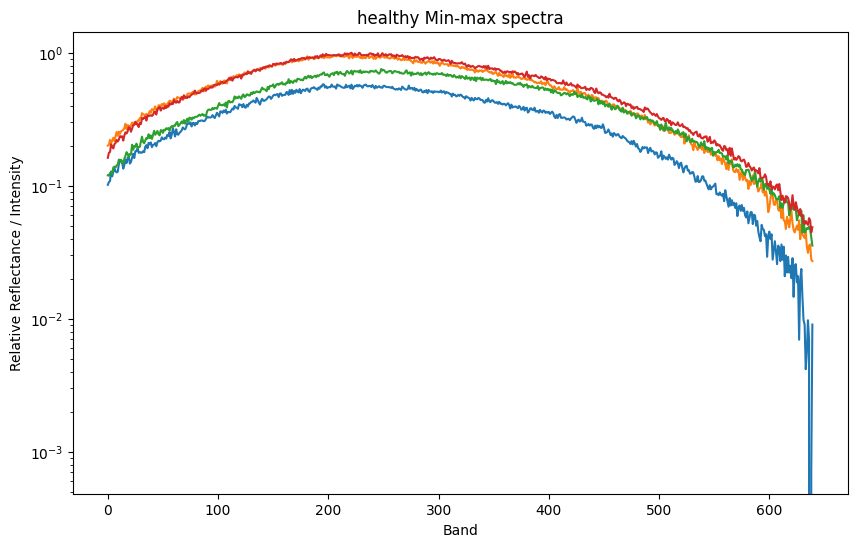

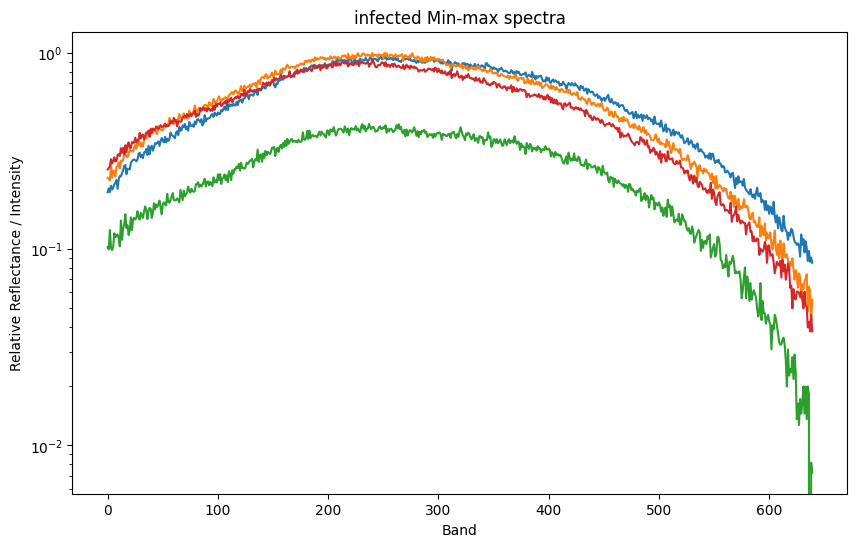

In [90]:
plot_spectra(healthy_minmax_spectra, 'healthy Min-max spectra')
plot_spectra(infected_minmax_spectra, 'infected Min-max spectra')

In [91]:
def zscore_normalize(image):
    """
    Applies Z-Score normalization to a hyperspectral image.
    Each band is normalized independently to have zero mean and unit variance.
    
    Parameters:
        image (numpy.ndarray): Hyperspectral image with shape (H, W, B).
    Returns:
        numpy.ndarray: Z-Score normalized image with the same shape as input.
    """
    mean_vals = np.mean(image, axis=(0, 1), keepdims=True)  # Mean per band
    std_vals = np.std(image, axis=(0, 1), keepdims=True)  # Standard deviation per band
    normalized = (image - mean_vals) / (std_vals + 1e-8)  # Avoid division by zero
    return normalized

healthy_zscore_spectra = zscore_normalize(healthy_seed_spectra)
infected_zscore_spectra = zscore_normalize(infected_seed_spectra)

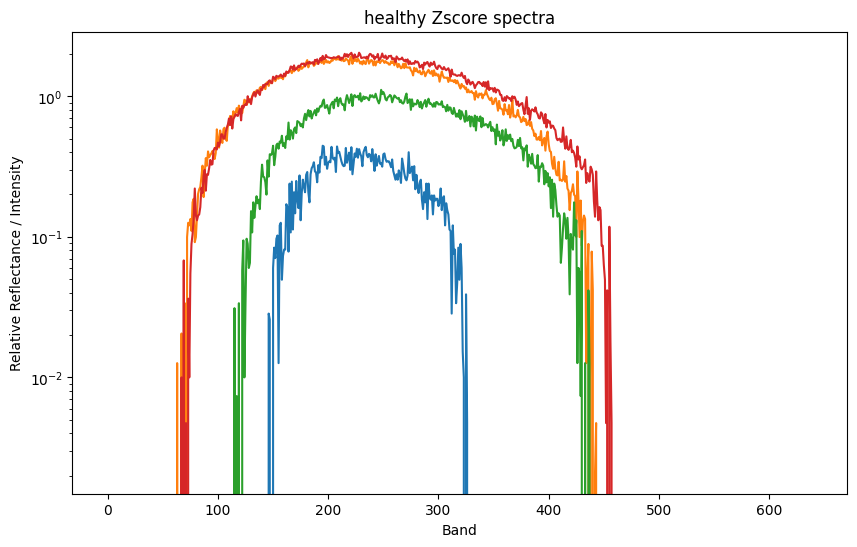

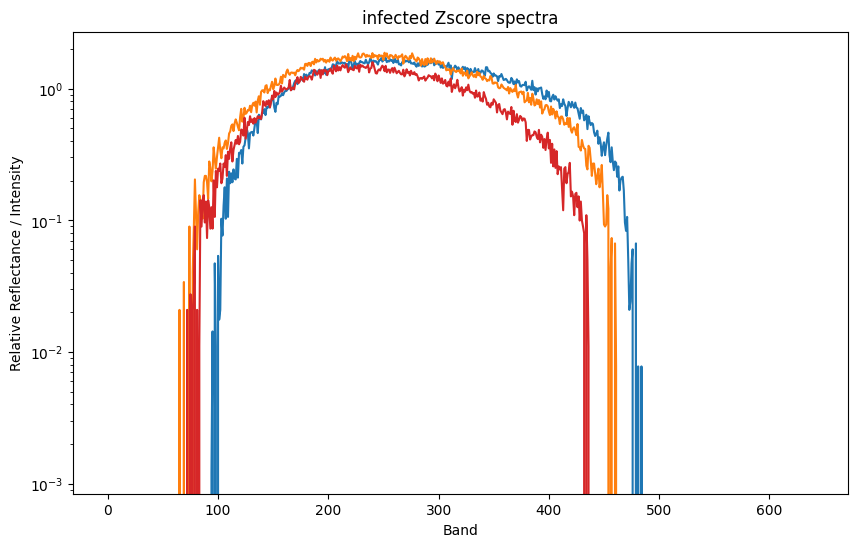

In [92]:
plot_spectra(healthy_zscore_spectra, 'healthy Zscore spectra')
plot_spectra(infected_zscore_spectra, 'infected Zscore spectra')